<a href="https://colab.research.google.com/github/andlljr/LunaLander/blob/main/LunaLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porque Deep Q-Network?

Para elaboração desse trabalho tentei implementar o Q-Learning utilizando uma tabela de estado e ação, entretanto, o estado do luna lander são muito grandes, já que dentro de um estado contém 8 observações, podendo gerar muitas combinações, então utilizei o Deep Q-Network, pois consegue lidar com grande quantidade de estados.

In [26]:
# Instalar bibliotecas
%pip install gymnasium
%pip install swig
%pip install gymnasium[box2d]

In [27]:
# Importar bibliotecas
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

In [33]:
# Visualização do ambiente por Frame
def display_video(frames):
    orig_backend = plt.get_backend()
    plt.switch_backend('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.switch_backend(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [29]:
# Criação de uma classe DQN que irá executar o algoritmo
class Dqn:
  def __init__(self, state_size, action_size):
    # Define os hiperparametros do modelo
    self.n_actions = action_size
    self.learning_rate = 0.001
    self.gamma = 0.99
    self.epsilon = 1.0
    self.epsilon_decay = 0.005
    self.batch_size = 32

    # Armazenar a experiência do algoritmo, limitando um número máximo evitando overfitting
    self.memory_buffer= list()
    self.max_memory_buffer = 2000

    # Rede neural sequencial com as informações do estado de input e como output a qualidade das ações
    self.model = Sequential([
        Dense(units=24,input_dim=state_size, activation = 'relu'),
        Dense(units=16,activation = 'relu'),
        Dense(units=action_size, activation = 'linear')
    ])
    self.model.compile(loss="mse", optimizer = Adam(learning_rate=self.learning_rate))


  # O agente irá tomar uma ação dado o estado atual
  def act(self, current_state):
      # Usa a técnica epsilon-greedy para tomada de ações
      if np.random.uniform(0,1) < self.epsilon:
          return np.random.choice(range(self.n_actions))
      q_values = self.model.predict(current_state)[0]
      return np.argmax(q_values)

  # Atualiza o valor de epsilon
  def updateEpsilon(self):
      self.epsilon = self.epsilon * np.exp(-self.epsilon_decay)
      print(self.epsilon)

  # Salva a experiência a cada passo
  def saveExperience(self,current_state, action, reward, next_state, done):
      self.memory_buffer.append({
          "current_state":current_state,
          "action":action,
          "reward":reward,
          "next_state":next_state,
          "done" :done
      })
      # Caso atingir o limite de memória, remover o mais antigo
      if len(self.memory_buffer) > self.max_memory_buffer:
          self.memory_buffer.pop(0)


  # Treinar o modelo a cada episódio
  def train(self):
      np.random.shuffle(self.memory_buffer)
      batch_sample = self.memory_buffer[0:self.batch_size]
      for experience in batch_sample:
          # Calcula o valor de Q
          q_current_state = self.model.predict(experience["current_state"])
          # Calcula o valor do Q target utilizando bellman
          q_target = experience["reward"]
          if not experience["done"]:
              q_target = q_target + self.gamma*np.max(self.model.predict(experience["next_state"])[0])
          q_current_state[0][experience["action"]] = q_target
          # Treina o modelo
          self.model.fit(experience["current_state"], q_current_state, verbose=0)

In [ ]:
# Inicia o ambiente do luna lander
env = gym.make("LunarLander-v2", render_mode="rgb_array")

state_size = 8
action_size = 4
rewards = []
frames_per_episode = []

# Defina o número máximo de passos por episódio
max_step = 1000
batch_size = 32

# Define o agente
agent = Dqn(state_size, action_size)
total_steps = 0
episodes = 50

for episode in range(episodes):
  current_state = env.reset()
  current_state = np.array([current_state])
  total_reward = 0
  episode_frames = []

  for step in range(max_step):
      total_steps = total_steps + 1
      action = agent.act(current_state)
      next_state, reward, done, _ = env.step(action)
      next_state = np.array([next_state])
      agent.saveExperience(current_state, action, reward, next_state, done)
      total_reward = total_reward + reward
      episode_frames.append(env.render(mode='rgb_array')[0])

      if done:
        agent.updateEpsilon()
        break

      current_state = next_state

  if total_steps >= batch_size:
    agent.train()

  frames_per_episode.extend(episode_frames)
  rewards.append(total_reward)
  print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")


# Resultado


Neste gráfico percebe-se que os hiperparâmetros devem ser ajustados, pois as recompensas estão variando muito, ele atinge um patamar bom e logo em seguida cai, algums das melhoras pode ser rodar mais episódios para ver se o modelo irá continuar esse comportamento ou irá maximizar a recompensa, lembrando que o gráfico mostra o total de recompensa por episódio. O intuito de fazer alterações é fazer com que a recompensa esteja sempre no patamar mais alto.

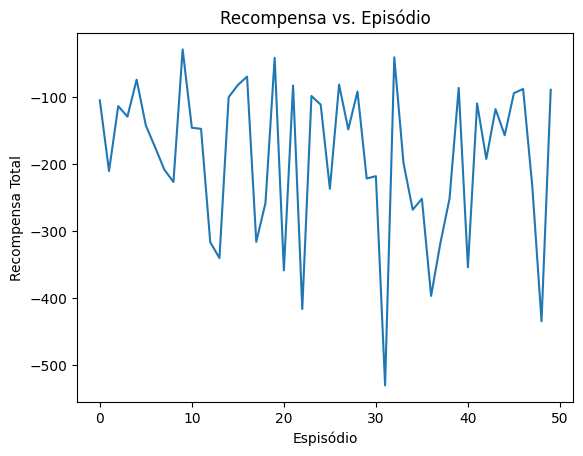

In [39]:
# Plot rewards
plt.plot(rewards)
plt.xlabel('Espisódio')
plt.ylabel('Recompensa Total')
plt.title('Recompensa vs. Episódio')
plt.show()

In [44]:
print(rewards)

[-266.18305428719407, -347.20493989326116, -336.4296661912714, -516.7192705057264, -86.56541216623098, -159.3079087441294, -223.99892833009545, -131.4265001505863, -395.6170135142802, -112.16730875987257, -122.348303904651, -24.86892900108495, -234.13225273854343, -35.39700659101605, -455.0429012652596]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualização em video do Luna Lander

In [43]:
display_video(frames_per_episode)